In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MODEL COMPARISON: LINEAR REGRESSION vs LSTM")
print("="*70)
print("\n✓ Libraries imported successfully\n")


MODEL COMPARISON: LINEAR REGRESSION vs LSTM

✓ Libraries imported successfully



In [4]:
# Cell 2: Load Data
print("Loading data...")
df = pd.read_csv('../data/aapl_stock.csv')

# Ensure numeric types
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

print(f"✓ Data loaded: {df.shape[0]} samples")
print(f"  Date range: {df.index[0] if hasattr(df.index, 'name') else 'Index 0'} to {df.index[-1] if hasattr(df.index, 'name') else f'Index {len(df)-1}'}")
print(f"  Close price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")


Loading data...
✓ Data loaded: 1509 samples
  Date range: 2 to 1510
  Close price range: $33.83 - $196.45


In [5]:
# Cell 3: Train Linear Regression Model
print("\n" + "="*70)
print("TRAINING LINEAR REGRESSION MODEL")
print("="*70)

# Create lag features
def create_features(df, n_lags=5):
    df_feat = pd.DataFrame(index=df.index)
    df_feat["Close"] = df["Close"]
    for lag in range(1, n_lags+1):
        df_feat[f"lag_{lag}"] = df["Close"].shift(lag)
    df_feat = df_feat.dropna()
    return df_feat

df_feat = create_features(df, n_lags=5)
X_lr = df_feat.drop("Close", axis=1).values
y_lr = df_feat["Close"].values

# Scale and split
scaler_lr = MinMaxScaler()
X_lr_scaled = scaler_lr.fit_transform(X_lr)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr_scaled, y_lr, test_size=0.2, shuffle=False
)

print(f"\nLinear Regression Data:")
print(f"  Training samples: {len(X_train_lr)}")
print(f"  Test samples: {len(X_test_lr)}")
print(f"  Features: {X_train_lr.shape[1]}")

# Train model
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)
print("✓ Training complete")

# Predictions
y_train_pred_lr = lr_model.predict(X_train_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)

# Metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train_lr, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test_lr, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train_lr, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test_lr, y_test_pred_lr)
lr_train_r2 = r2_score(y_train_lr, y_train_pred_lr)
lr_test_r2 = r2_score(y_test_lr, y_test_pred_lr)

print(f"\nLinear Regression Results:")
print(f"  Train RMSE: {lr_train_rmse:.4f} | Test RMSE: {lr_test_rmse:.4f}")
print(f"  Train MAE:  {lr_train_mae:.4f} | Test MAE:  {lr_test_mae:.4f}")
print(f"  Train R²:   {lr_train_r2:.4f} | Test R²:   {lr_test_r2:.4f}")



TRAINING LINEAR REGRESSION MODEL

Linear Regression Data:
  Training samples: 1203
  Test samples: 301
  Features: 5

Training Linear Regression...
✓ Training complete

Linear Regression Results:
  Train RMSE: 2.0888 | Test RMSE: 2.4552
  Train MAE:  1.3924 | Test MAE:  1.8310
  Train R²:   0.9979 | Test R²:   0.9842


In [6]:
# Cell 4: Train LSTM Model
print("\n" + "="*70)
print("TRAINING LSTM MODEL")
print("="*70)

# Prepare LSTM data
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

close_data = df['Close'].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_lstm.fit_transform(close_data)

# Split
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

# Create sequences
sequence_length = 60
X_train_lstm, y_train_lstm = create_sequences(train_data, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(test_data, sequence_length)

# Reshape
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

print(f"\nLSTM Data:")
print(f"  Training samples: {len(X_train_lstm)}")
print(f"  Test samples: {len(X_test_lstm)}")
print(f"  Sequence length: {sequence_length}")

# Build LSTM model
print("\nBuilding LSTM model...")
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print(f"✓ Model built with {lstm_model.count_params():,} parameters")

# Train LSTM
print("\nTraining LSTM (this may take a few minutes)...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)
print(f"✓ Training complete ({len(history.history['loss'])} epochs)")

# Predictions
y_train_pred_lstm_scaled = lstm_model.predict(X_train_lstm, verbose=0)
y_test_pred_lstm_scaled = lstm_model.predict(X_test_lstm, verbose=0)

# Inverse transform
y_train_pred_lstm = scaler_lstm.inverse_transform(y_train_pred_lstm_scaled)
y_test_pred_lstm = scaler_lstm.inverse_transform(y_test_pred_lstm_scaled)
y_train_lstm_actual = scaler_lstm.inverse_transform(y_train_lstm.reshape(-1, 1))
y_test_lstm_actual = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

# Metrics
lstm_train_rmse = np.sqrt(mean_squared_error(y_train_lstm_actual, y_train_pred_lstm))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_lstm_actual, y_test_pred_lstm))
lstm_train_mae = mean_absolute_error(y_train_lstm_actual, y_train_pred_lstm)
lstm_test_mae = mean_absolute_error(y_test_lstm_actual, y_test_pred_lstm)
lstm_train_r2 = r2_score(y_train_lstm_actual, y_train_pred_lstm)
lstm_test_r2 = r2_score(y_test_lstm_actual, y_test_pred_lstm)

print(f"\nLSTM Results:")
print(f"  Train RMSE: {lstm_train_rmse:.4f} | Test RMSE: {lstm_test_rmse:.4f}")
print(f"  Train MAE:  {lstm_train_mae:.4f} | Test MAE:  {lstm_test_mae:.4f}")
print(f"  Train R²:   {lstm_train_r2:.4f} | Test R²:   {lstm_test_r2:.4f}")



TRAINING LSTM MODEL

LSTM Data:
  Training samples: 1147
  Test samples: 302
  Sequence length: 60

Building LSTM model...
✓ Model built with 30,651 parameters

Training LSTM (this may take a few minutes)...
✓ Training complete (50 epochs)

LSTM Results:
  Train RMSE: 3.5332 | Test RMSE: 5.4275
  Train MAE:  2.4416 | Test MAE:  4.6844
  Train R²:   0.9940 | Test R²:   0.9229


In [7]:
# Cell 5: Comparison Summary
print("\n" + "="*70)
print("DETAILED COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_data = {
    'Metric': ['RMSE (Train)', 'RMSE (Test)', 'MAE (Train)', 'MAE (Test)', 'R² (Train)', 'R² (Test)'],
    'Linear Regression': [
        f'{lr_train_rmse:.4f}',
        f'{lr_test_rmse:.4f}',
        f'{lr_train_mae:.4f}',
        f'{lr_test_mae:.4f}',
        f'{lr_train_r2:.4f}',
        f'{lr_test_r2:.4f}'
    ],
    'LSTM': [
        f'{lstm_train_rmse:.4f}',
        f'{lstm_test_rmse:.4f}',
        f'{lstm_train_mae:.4f}',
        f'{lstm_test_mae:.4f}',
        f'{lstm_train_r2:.4f}',
        f'{lstm_test_r2:.4f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Calculate improvements
rmse_improvement = ((lr_test_rmse - lstm_test_rmse) / lr_test_rmse) * 100
mae_improvement = ((lr_test_mae - lstm_test_mae) / lr_test_mae) * 100
r2_improvement = ((lstm_test_r2 - lr_test_r2) / lr_test_r2) * 100

print("\n" + "-"*70)
print("PERFORMANCE IMPROVEMENT (LSTM vs Linear Regression)")
print("-"*70)
print(f"  RMSE: {rmse_improvement:+.2f}% {'(Better)' if rmse_improvement > 0 else '(Worse)'}")
print(f"  MAE:  {mae_improvement:+.2f}% {'(Better)' if mae_improvement > 0 else '(Worse)'}")
print(f"  R²:   {r2_improvement:+.2f}% {'(Better)' if r2_improvement > 0 else '(Worse)'}")



DETAILED COMPARISON

       Metric Linear Regression   LSTM
RMSE (Train)            2.0888 3.5332
 RMSE (Test)            2.4552 5.4275
 MAE (Train)            1.3924 2.4416
  MAE (Test)            1.8310 4.6844
  R² (Train)            0.9979 0.9940
   R² (Test)            0.9842 0.9229

----------------------------------------------------------------------
PERFORMANCE IMPROVEMENT (LSTM vs Linear Regression)
----------------------------------------------------------------------
  RMSE: -121.06% (Worse)
  MAE:  -155.83% (Worse)
  R²:   -6.23% (Worse)


In [8]:
# Cell 6: Determine Winner
print("\n" + "="*70)
print("WINNER DETERMINATION")
print("="*70)

# Count wins
lr_wins = 0
lstm_wins = 0

# Lower RMSE is better
if lr_test_rmse < lstm_test_rmse:
    lr_wins += 1
    print("\n✓ Linear Regression wins on RMSE")
else:
    lstm_wins += 1
    print("\n✓ LSTM wins on RMSE")

# Lower MAE is better
if lr_test_mae < lstm_test_mae:
    lr_wins += 1
    print("✓ Linear Regression wins on MAE")
else:
    lstm_wins += 1
    print("✓ LSTM wins on MAE")

# Higher R² is better
if lr_test_r2 > lstm_test_r2:
    lr_wins += 1
    print("✓ Linear Regression wins on R²")
else:
    lstm_wins += 1
    print("✓ LSTM wins on R²")

print("\n" + "-"*70)
print(f"Score: Linear Regression {lr_wins} - {lstm_wins} LSTM")
print("-"*70)

if lstm_wins > lr_wins:
    winner = "LSTM"
    winner_rmse = lstm_test_rmse
    winner_r2 = lstm_test_r2
else:
    winner = "Linear Regression"
    winner_rmse = lr_test_rmse
    winner_r2 = lr_test_r2

print(f"\n🏆 WINNER: {winner}")
print(f"   Best Test RMSE: ${winner_rmse:.4f}")
print(f"   Best Test R²: {winner_r2:.4f}")



WINNER DETERMINATION

✓ Linear Regression wins on RMSE
✓ Linear Regression wins on MAE
✓ Linear Regression wins on R²

----------------------------------------------------------------------
Score: Linear Regression 3 - 0 LSTM
----------------------------------------------------------------------

🏆 WINNER: Linear Regression
   Best Test RMSE: $2.4552
   Best Test R²: 0.9842


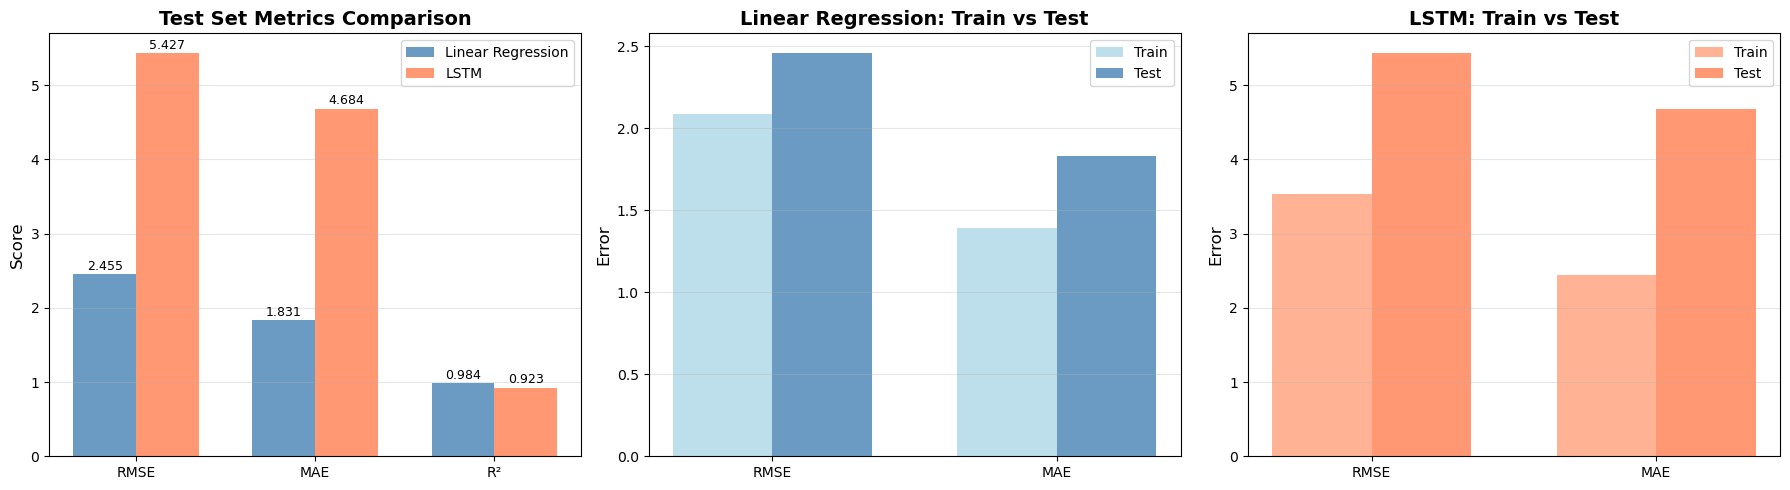

In [9]:
# Cell 7: Visualize Metrics Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RMSE', 'MAE', 'R²']
lr_test_values = [lr_test_rmse, lr_test_mae, lr_test_r2]
lstm_test_values = [lstm_test_rmse, lstm_test_mae, lstm_test_r2]

x = np.arange(len(metrics))
width = 0.35

# Plot 1: Test Metrics
axes[0].bar(x - width/2, lr_test_values, width, label='Linear Regression', 
            color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, lstm_test_values, width, label='LSTM', 
            color='coral', alpha=0.8)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Test Set Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (lr_val, lstm_val) in enumerate(zip(lr_test_values, lstm_test_values)):
    axes[0].text(i - width/2, lr_val + 0.02, f'{lr_val:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, lstm_val + 0.02, f'{lstm_val:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 2: Training vs Test (Linear Regression)
lr_metrics = ['RMSE', 'MAE']
lr_train = [lr_train_rmse, lr_train_mae]
lr_test = [lr_test_rmse, lr_test_mae]

x2 = np.arange(len(lr_metrics))
axes[1].bar(x2 - width/2, lr_train, width, label='Train', color='lightblue', alpha=0.8)
axes[1].bar(x2 + width/2, lr_test, width, label='Test', color='steelblue', alpha=0.8)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Linear Regression: Train vs Test', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(lr_metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Training vs Test (LSTM)
lstm_train = [lstm_train_rmse, lstm_train_mae]
lstm_test = [lstm_test_rmse, lstm_test_mae]

axes[2].bar(x2 - width/2, lstm_train, width, label='Train', color='lightsalmon', alpha=0.8)
axes[2].bar(x2 + width/2, lstm_test, width, label='Test', color='coral', alpha=0.8)
axes[2].set_ylabel('Error', fontsize=12)
axes[2].set_title('LSTM: Train vs Test', fontsize=14, fontweight='bold')
axes[2].set_xticks(x2)
axes[2].set_xticklabels(lr_metrics)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


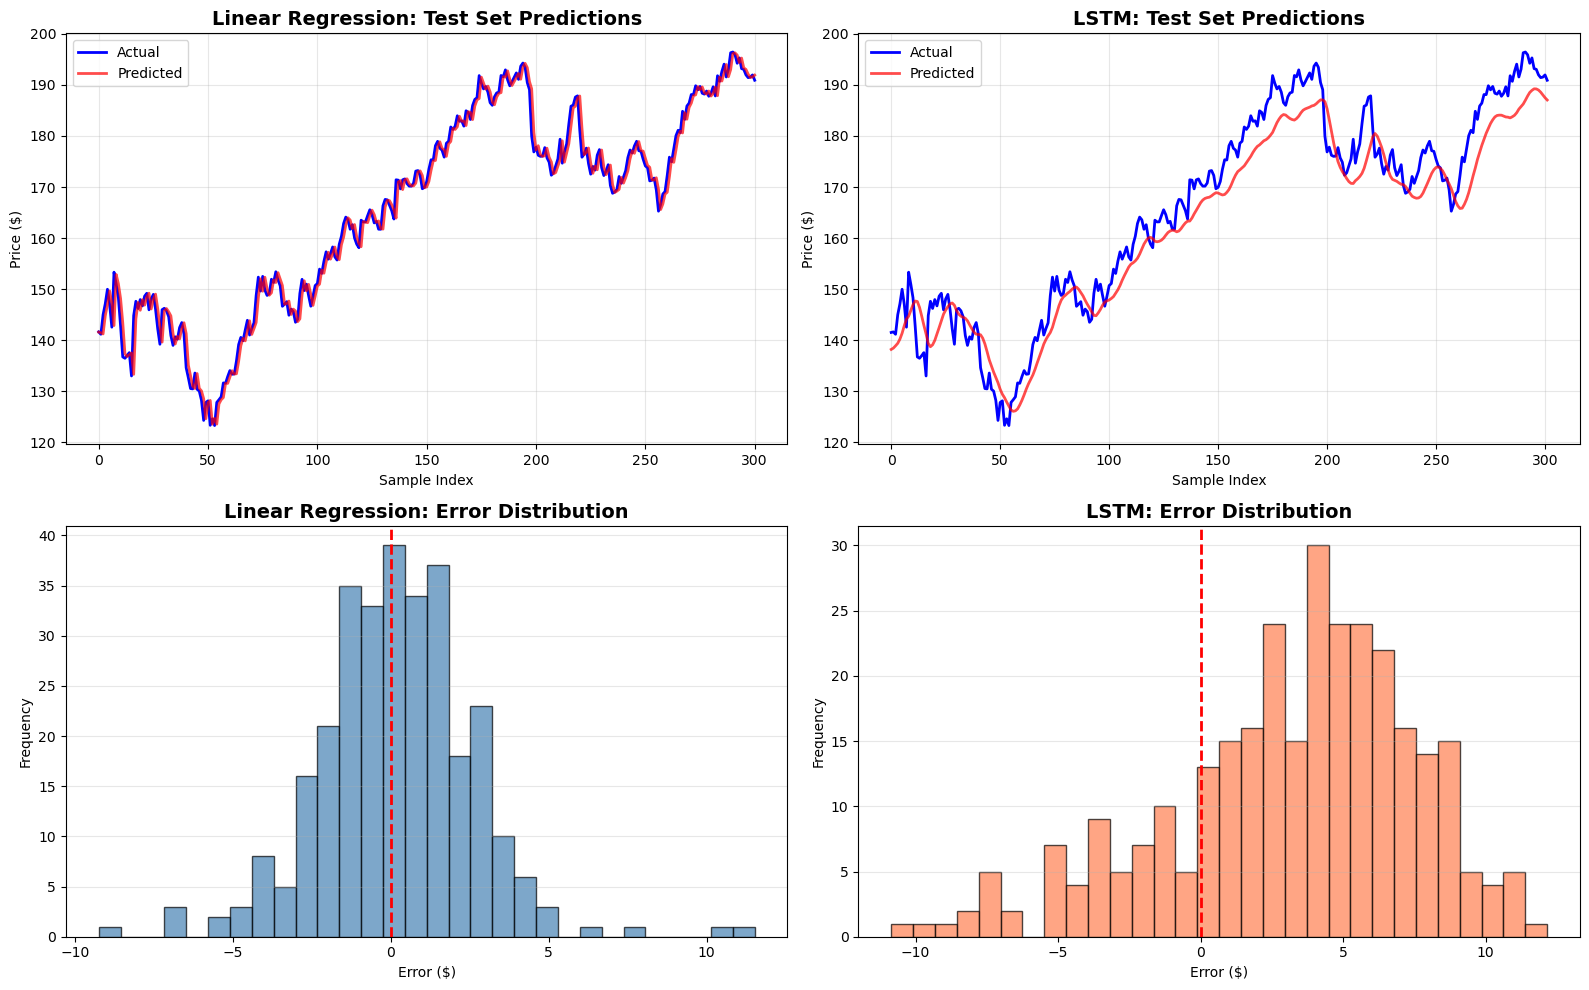

In [10]:
# Cell 8: Visualize Predictions Side by Side
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Linear Regression Predictions
axes[0, 0].plot(y_test_lr, label='Actual', linewidth=2, color='blue')
axes[0, 0].plot(y_test_pred_lr, label='Predicted', linewidth=2, alpha=0.7, color='red')
axes[0, 0].set_title('Linear Regression: Test Set Predictions', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: LSTM Predictions
axes[0, 1].plot(y_test_lstm_actual, label='Actual', linewidth=2, color='blue')
axes[0, 1].plot(y_test_pred_lstm, label='Predicted', linewidth=2, alpha=0.7, color='red')
axes[0, 1].set_title('LSTM: Test Set Predictions', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Linear Regression Errors
lr_errors = y_test_lr - y_test_pred_lr
axes[1, 0].hist(lr_errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Linear Regression: Error Distribution', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: LSTM Errors
lstm_errors = y_test_lstm_actual.flatten() - y_test_pred_lstm.flatten()
axes[1, 1].hist(lstm_errors, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('LSTM: Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Error ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [11]:
# Cell 9: Error Analysis Comparison
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

print("\nLinear Regression Errors:")
print(f"  Mean Error:   {lr_errors.mean():.4f}")
print(f"  Std Error:    {lr_errors.std():.4f}")
print(f"  Min Error:    {lr_errors.min():.4f}")
print(f"  Max Error:    {lr_errors.max():.4f}")

print("\nLSTM Errors:")
print(f"  Mean Error:   {lstm_errors.mean():.4f}")
print(f"  Std Error:    {lstm_errors.std():.4f}")
print(f"  Min Error:    {lstm_errors.min():.4f}")
print(f"  Max Error:    {lstm_errors.max():.4f}")

# Accuracy within thresholds
lr_within_1 = np.sum(np.abs(lr_errors) <= 1) / len(lr_errors) * 100
lr_within_2 = np.sum(np.abs(lr_errors) <= 2) / len(lr_errors) * 100
lstm_within_1 = np.sum(np.abs(lstm_errors) <= 1) / len(lstm_errors) * 100
lstm_within_2 = np.sum(np.abs(lstm_errors) <= 2) / len(lstm_errors) * 100

print("\nPrediction Accuracy (within threshold):")
print(f"  Linear Regression: {lr_within_1:.1f}% within $1, {lr_within_2:.1f}% within $2")
print(f"  LSTM:              {lstm_within_1:.1f}% within $1, {lstm_within_2:.1f}% within $2")



ERROR ANALYSIS

Linear Regression Errors:
  Mean Error:   0.1653
  Std Error:    2.4496
  Min Error:    -9.2531
  Max Error:    11.5187

LSTM Errors:
  Mean Error:   3.1857
  Std Error:    4.3942
  Min Error:    -10.8537
  Max Error:    12.1621

Prediction Accuracy (within threshold):
  Linear Regression: 35.2% within $1, 64.8% within $2
  LSTM:              8.6% within $1, 20.5% within $2


In [12]:
# Cell 10: Model Characteristics Comparison
print("\n" + "="*70)
print("MODEL CHARACTERISTICS")
print("="*70)

characteristics = {
    'Characteristic': [
        'Training Time',
        'Prediction Speed',
        'Memory Usage',
        'Complexity',
        'Interpretability',
        'Best For',
        'Parameters'
    ],
    'Linear Regression': [
        'Very Fast (~seconds)',
        'Very Fast',
        'Low',
        'Simple',
        'High (clear coefficients)',
        'Short-term (1-7 days)',
        f'{lr_model.coef_.size} parameters'
    ],
    'LSTM': [
        'Slow (~minutes)',
        'Moderate',
        'High',
        'Complex',
        'Low (black box)',
        'Long-term (7-90 days)',
        f'{lstm_model.count_params():,} parameters'
    ]
}

char_df = pd.DataFrame(characteristics)
print("\n", char_df.to_string(index=False))


MODEL CHARACTERISTICS

   Characteristic         Linear Regression                  LSTM
   Training Time      Very Fast (~seconds)       Slow (~minutes)
Prediction Speed                 Very Fast              Moderate
    Memory Usage                       Low                  High
      Complexity                    Simple               Complex
Interpretability High (clear coefficients)       Low (black box)
        Best For     Short-term (1-7 days) Long-term (7-90 days)
      Parameters              5 parameters     30,651 parameters


In [13]:
# Cell 11: Final Recommendation
print("\n" + "="*70)
print("FINAL RECOMMENDATION")
print("="*70)

print(f"\n🏆 Overall Winner: {winner}")
print("\nRecommendations:")

if winner == "LSTM":
    print("\n✓ Use LSTM when:")
    print("  - You need high accuracy")
    print("  - Making long-term predictions (7+ days)")
    print("  - Computational resources are available")
    print("  - Training time is not critical")
    
    print("\n✓ Use Linear Regression when:")
    print("  - You need fast predictions")
    print("  - Making short-term predictions (1-5 days)")
    print("  - Limited computational resources")
    print("  - Model interpretability is important")
else:
    print("\n✓ Use Linear Regression when:")
    print("  - You need fast predictions")
    print("  - Making short-term predictions")
    print("  - Model interpretability is important")
    
    print("\n✓ Use LSTM when:")
    print("  - Making long-term predictions")
    print("  - More computational resources available")



FINAL RECOMMENDATION

🏆 Overall Winner: Linear Regression

Recommendations:

✓ Use Linear Regression when:
  - You need fast predictions
  - Making short-term predictions
  - Model interpretability is important

✓ Use LSTM when:
  - Making long-term predictions
  - More computational resources available


In [14]:
# Cell 12: Summary Statistics
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\nDataset: {len(df)} samples")
print(f"Test Size: {len(y_test_lr)} samples")

print(f"\n📊 Linear Regression:")
print(f"   RMSE: ${lr_test_rmse:.4f}")
print(f"   R²: {lr_test_r2:.4f} ({lr_test_r2*100:.2f}% variance explained)")

print(f"\n📊 LSTM:")
print(f"   RMSE: ${lstm_test_rmse:.4f}")
print(f"   R²: {lstm_test_r2:.4f} ({lstm_test_r2*100:.2f}% variance explained)")

print(f"\n🎯 Performance Gap:")
print(f"   RMSE Difference: ${abs(lr_test_rmse - lstm_test_rmse):.4f}")
print(f"   R² Difference: {abs(lr_test_r2 - lstm_test_r2):.4f}")

print("\n" + "="*70)
print("✅ COMPARISON COMPLETE")
print("="*70)


SUMMARY

Dataset: 1509 samples
Test Size: 301 samples

📊 Linear Regression:
   RMSE: $2.4552
   R²: 0.9842 (98.42% variance explained)

📊 LSTM:
   RMSE: $5.4275
   R²: 0.9229 (92.29% variance explained)

🎯 Performance Gap:
   RMSE Difference: $2.9723
   R² Difference: 0.0613

✅ COMPARISON COMPLETE
